In [3]:
### COMMENT OUT IF RUNNING LOCALLY (NOT VIA GOOGLE COLAB) ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

def read_csv(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    print(csv_file_path)
    print('Shape:', df.shape)
    print(df.head())
    return df

In [5]:
input_data = read_csv('/content/drive/MyDrive/final_dfs/final_static_data.csv')

<ipython-input-4-08f417b51748>:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


/content/drive/MyDrive/final_dfs/final_static_data.csv
Shape: (109751, 1789)
   subject_id            charttime     hadm_id         duration  \
0    16925328  2151-05-25 15:03:00  20000024.0   75120000000000   
1    11146739  2190-01-15 14:41:00  20000057.0  255480000000000   
2    14546051  2130-12-10 00:00:00  20000069.0  175560000000000   
3    13074106  2135-05-20 00:00:00  20000102.0  296880000000000   
4    13559141  2174-12-06 00:00:00  20000347.0  177780000000000   

     microbiology_orgname curr_service   care_unit_group disposition  \
0                     NaN          MED         Emergency        HOME   
1                     NaN          MED         Emergency     UNKNOWN   
2  GRAM POSITIVE BACTERIA          OBS  Labor & Delivery        HOME   
3                     NaN          OBS  Labor & Delivery        HOME   
4     SERRATIA MARCESCENS          MED         Emergency     UNKNOWN   

   is_ed_visit  is_urgent_lab_event  ...                       race  \
0            0  

In [6]:
output_data = read_csv('/content/drive/MyDrive/final_dfs/target_outputs.csv')

/content/drive/MyDrive/final_dfs/target_outputs.csv
Shape: (19076, 5)
   subject_id  preeclampsia_output  preterm_output  hemorrhage_output  \
0    16925328                    0               0                  0   
1    11146739                    0               0                  0   
2    14546051                    0               0                  0   
3    13074106                    0               1                  1   
4    13559141                    0               0                  0   

   has_adverse_outcome  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0  


### Format input/output data for EDA
- for admissions-level data, add the output data (merge on subject id)
- create aggregated represenation of the input data, and combine with the output data (merge on subject id)

In [7]:
def aggregate_by_subject(df):
    """
    Aggregates a DataFrame by subject_id.
    """
    numeric_cols = ['age_at_admission', 'mean_patient_weight']
    boolean_cols = [col for col in df.columns if col not in numeric_cols + ['subject_id']]

    aggregation_functions = {col: 'mean' for col in numeric_cols}
    aggregation_functions.update({col: 'first' for col in boolean_cols})

    aggregated_df = df.groupby('subject_id').agg(aggregation_functions).reset_index()
    aggregated_df.sort_values(by='subject_id', inplace=True)

    return aggregated_df

In [8]:
# drop charttime, duration since no longer needed
input_data = input_data.drop(columns=['charttime', 'duration'])
aggregated_input_data = aggregate_by_subject(input_data)

In [9]:
input_data_with_targets = pd.merge(input_data, output_data, on='subject_id', how='left')

In [10]:
aggregated_input_data_with_targets = pd.merge(aggregated_input_data, output_data, on='subject_id', how='left')

## Patient Demographics EDA

### Race

In [11]:
aggregated_input_data['race'].value_counts()

,count
race,
Unknown,6832
White,6090
Black or African American,3374
Hispanic or Latino,1387
Asian,1249
Native American/Alaska Native,55
Mixed Race/Ethnicity,39
South American,34
Pacific Islander,16


In [12]:
color_mapping = {
    'White': 'green',
    'Black or African American': 'orange',
    'Hispanic or Latino': 'yellow',
    'Asian': 'lightblue',
    'Native American/Alaska Native': 'magenta',
    'Mixed Race/Ethnicity': 'gray',
    'South American': 'yellow',
    'Pacific Islander': 'lightblue'
}

<ipython-input-13-3273d66863b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=percentage_df, x='race', y='percentage', palette=color_mapping)


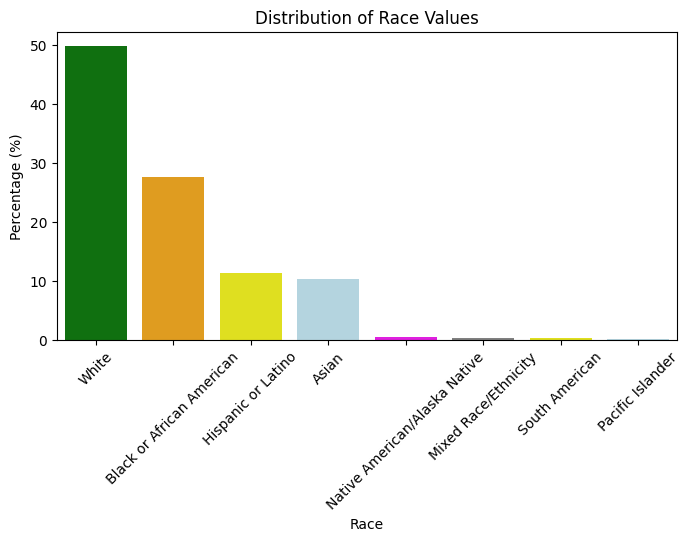

In [13]:
known_race_df = aggregated_input_data[aggregated_input_data['race'] != 'Unknown']
race_counts = known_race_df['race'].value_counts()
plt.figure(figsize=(8, 4))
percents = race_counts / race_counts.sum() * 100
percentage_df = pd.DataFrame({
    'race': percents.index,
    'percentage': percents.values
})
sns.barplot(data=percentage_df, x='race', y='percentage', palette=color_mapping)
plt.title('Distribution of Race Values')
plt.xlabel('Race')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.savefig('/content/drive/My Drive/capstone_imgs/race_distribution_percent.png', bbox_inches='tight')
plt.show()

In [14]:
race_outcome_counts = aggregated_input_data_with_targets.groupby(['race', 'has_adverse_outcome']).size().unstack(fill_value=0)
race_outcome_percentages = race_outcome_counts.div(race_outcome_counts.sum(axis=1), axis=0) * 100
percentage_df = race_outcome_percentages.reset_index().melt(id_vars=['race'], var_name='has_adverse_outcome', value_name='percentage')

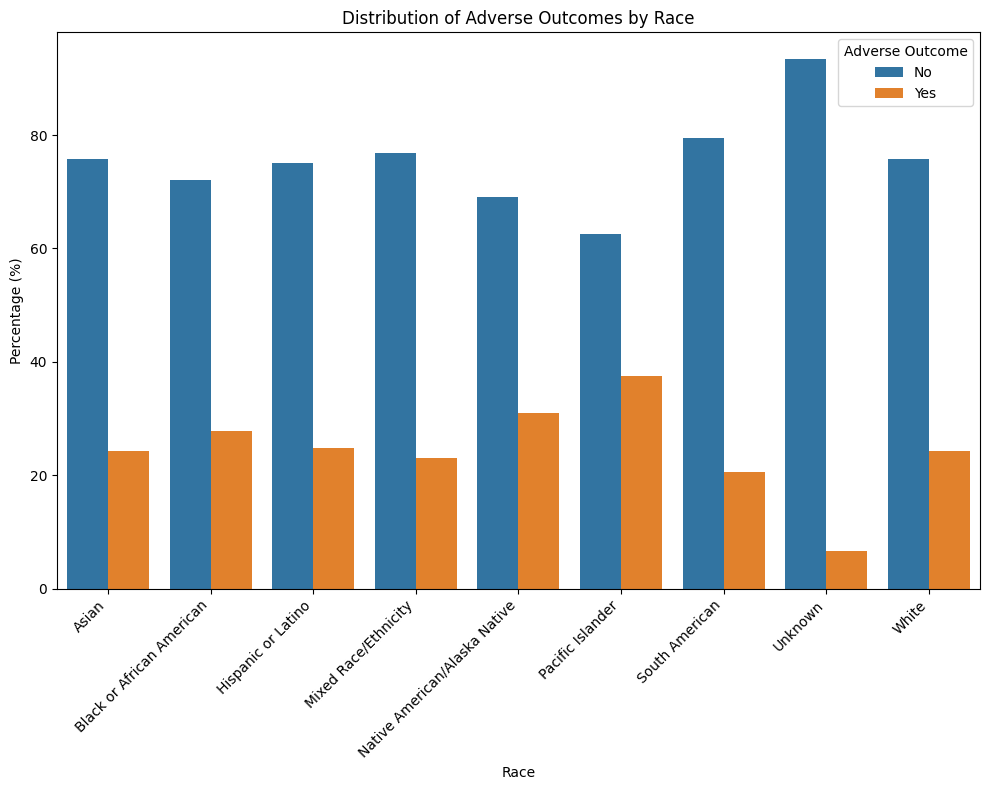

In [15]:
plt.figure(figsize=(10, 8))
plot = sns.barplot(data=percentage_df, x='race', y='percentage', hue='has_adverse_outcome')

plt.title('Distribution of Adverse Outcomes by Race')
plt.xlabel('Race')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

handles, _ = plot.get_legend_handles_labels()
legend_labels = ['No', 'Yes']
plt.legend(handles=handles, labels=legend_labels, title='Adverse Outcome', loc='upper right')

plt.tight_layout()

plt.savefig('/content/drive/My Drive/capstone_imgs/race_adverse_outcome_distribution.png', bbox_inches='tight')

plt.show()

### Language

In [16]:
aggregated_input_data['language'].value_counts()

,count
language,
ENGLISH,11385
UNKNOWN,7691


### Marital Status

In [17]:
aggregated_input_data['marital_status'].value_counts()

,count
marital_status,
MARRIED,7309
UNKNOWN,6636
SINGLE,4980
DIVORCED,139
WIDOWED,12


In [18]:
known_status_df = aggregated_input_data_with_targets[aggregated_input_data_with_targets['marital_status'] != 'UNKNOWN']

In [19]:
status_outcome_counts = known_status_df.groupby(['marital_status', 'has_adverse_outcome']).size().unstack(fill_value=0)
# convert to percentages
status_outcome_percentages = status_outcome_counts.div(status_outcome_counts.sum(axis=1), axis=0) * 100
# create as df which will be used for the plot
percentage_df = status_outcome_percentages.reset_index().melt(id_vars=['marital_status'], var_name='has_adverse_outcome', value_name='percentage')
percentage_df['marital_status'] = pd.Categorical(percentage_df['marital_status'])

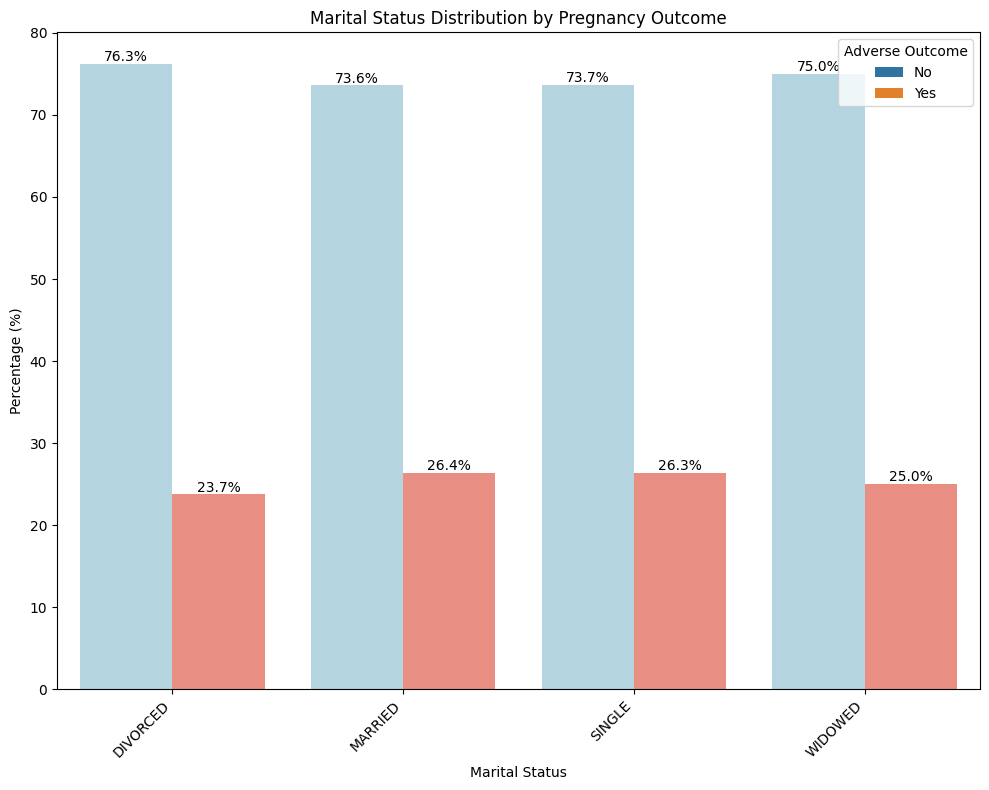

In [20]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=percentage_df, x='marital_status', y='percentage', hue='has_adverse_outcome', palette={0: 'lightblue', 1: 'salmon'})

plt.title('Marital Status Distribution by Pregnancy Outcome')
plt.xlabel('Marital Status')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')

handles, _ = plot.get_legend_handles_labels()
legend_labels = ['No', 'Yes']
plt.legend(handles=handles, labels=legend_labels, title='Adverse Outcome', loc='upper right')

# add actual percentages
for p in ax.patches:
    height = p.get_height()
    if height > 0:
      ax.annotate(f'{height:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='center',
                  xytext=(0, 5),
                  textcoords='offset points')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/capstone_imgs/marital_status_adverse_outcome_distribution.png', bbox_inches='tight')

plt.show()

<Figure size 1400x800 with 0 Axes>

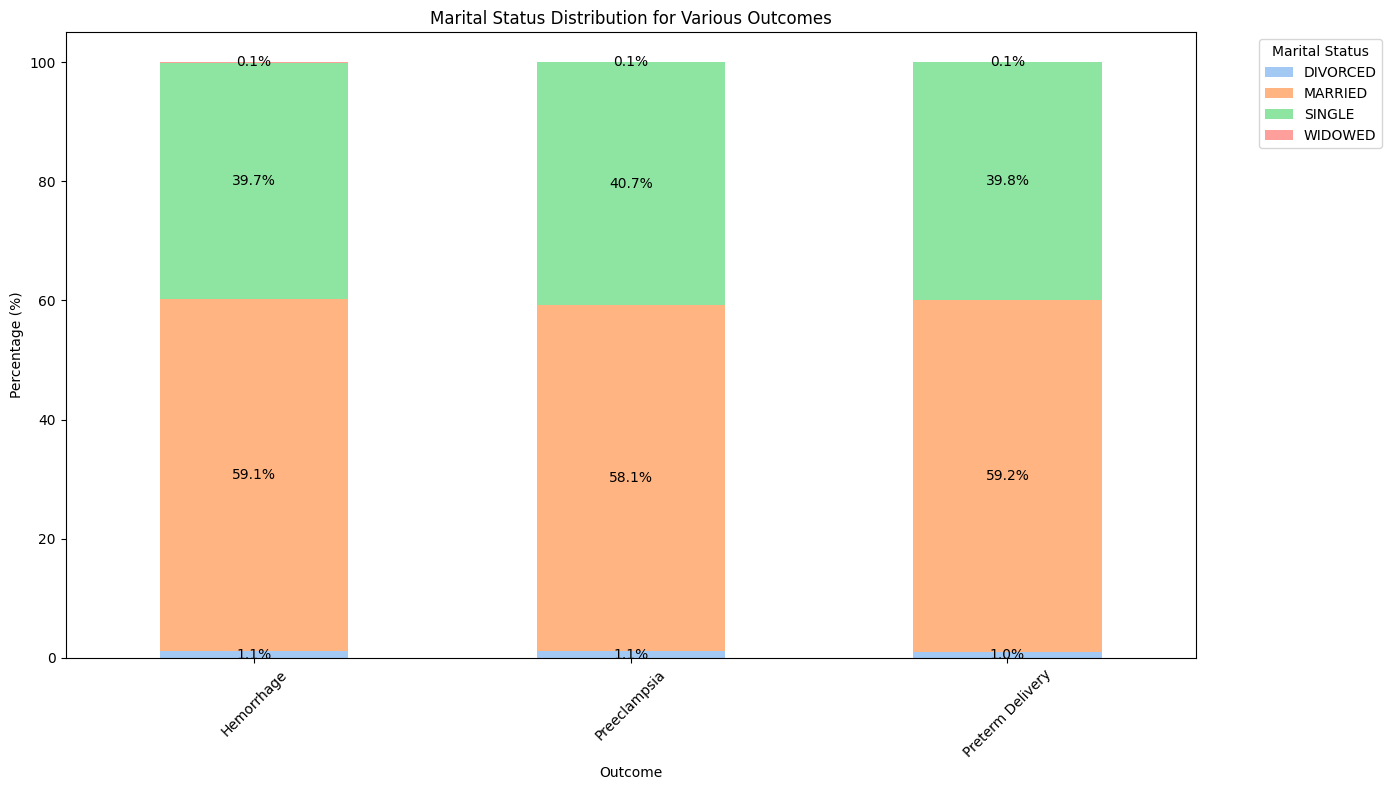

In [21]:
outcome_cols = ['preeclampsia_output', 'preterm_output', 'hemorrhage_output']
combined_data = []

def process_outcome(df, outcome_col):
    status_outcome_counts = df.groupby([outcome_col, 'marital_status']).size().unstack(fill_value=0)
    status_outcome_percentages = status_outcome_counts.div(status_outcome_counts.sum(axis=1), axis=0) * 100
    percentage_df = status_outcome_percentages.reset_index().melt(id_vars=[outcome_col], var_name='marital_status', value_name='percentage')
    percentage_df['outcome'] = outcome_col

    return percentage_df

for outcome_col in outcome_cols:
    combined_data.append(process_outcome(known_status_df, outcome_col))

all_data = pd.concat(combined_data)

custom_labels = {
    'preeclampsia_output': 'Preeclampsia',
    'preterm_output': 'Preterm Delivery',
    'hemorrhage_output': 'Hemorrhage'
}

stacked_df = all_data.pivot_table(index='outcome', columns='marital_status', values='percentage', fill_value=0)
stacked_df.index = [custom_labels.get(col, col) for col in stacked_df.index]

plt.figure(figsize=(14, 8))

pastel_palette = sns.color_palette("pastel", n_colors=stacked_df.shape[1])
ax = stacked_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=pastel_palette)

plt.title('Marital Status Distribution for Various Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/capstone_imgs/marital_status_by_outcomes.png', bbox_inches='tight')

plt.show()

### Insurance

In [22]:
aggregated_input_data_with_targets['insurance'].value_counts()

,count
insurance,
Other,10613
UNKNOWN,6360
Medicaid,1945
Medicare,158


In [23]:
known_status_df = aggregated_input_data_with_targets[aggregated_input_data_with_targets['insurance'] != 'UNKNOWN']

<Figure size 1400x800 with 0 Axes>

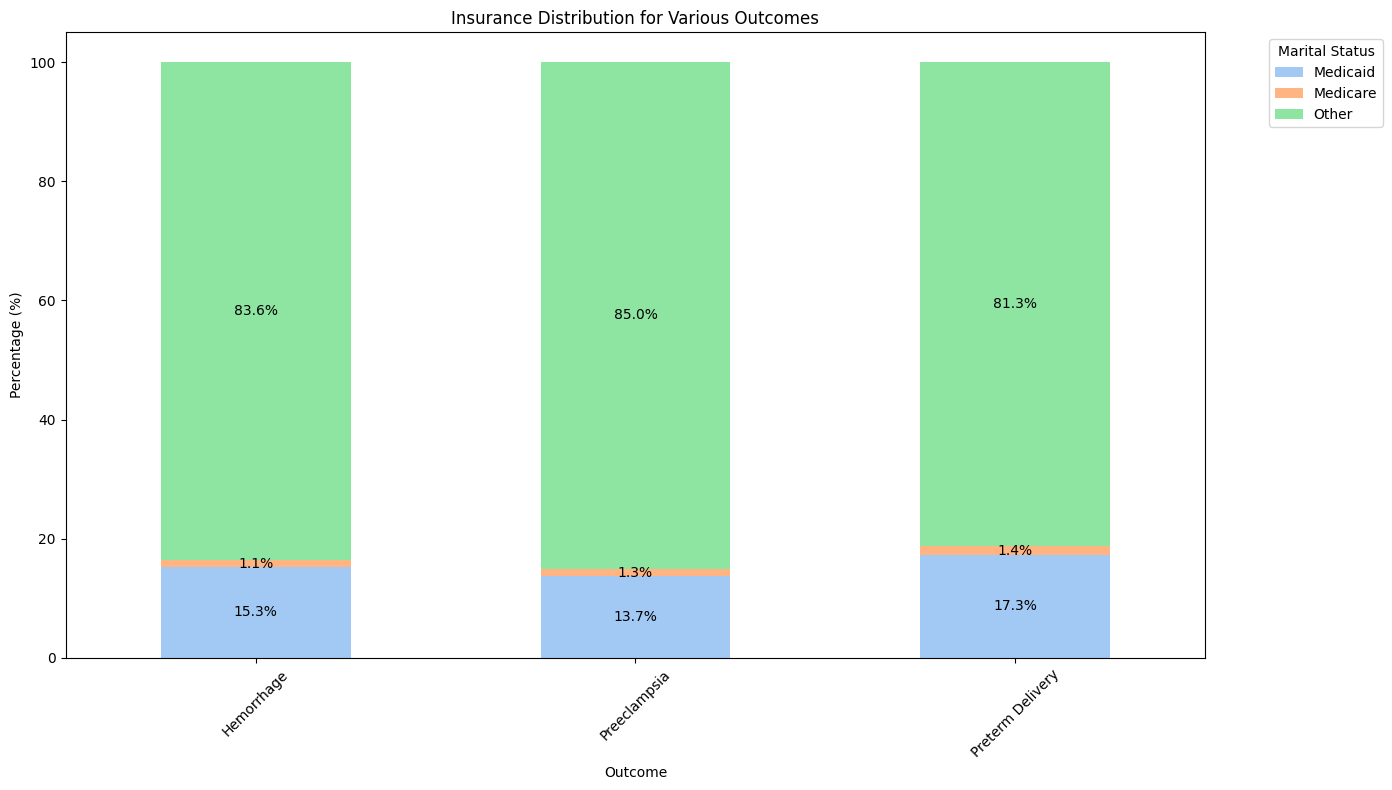

In [24]:
outcome_cols = ['preeclampsia_output', 'preterm_output', 'hemorrhage_output']
combined_data = []

def process_outcome(df, outcome_col):
    status_outcome_counts = df.groupby([outcome_col, 'insurance']).size().unstack(fill_value=0)
    status_outcome_percentages = status_outcome_counts.div(status_outcome_counts.sum(axis=1), axis=0) * 100
    percentage_df = status_outcome_percentages.reset_index().melt(id_vars=[outcome_col], var_name='insurance', value_name='percentage')
    percentage_df['outcome'] = outcome_col

    return percentage_df

for outcome_col in outcome_cols:
    combined_data.append(process_outcome(known_status_df, outcome_col))

all_data = pd.concat(combined_data)

custom_labels = {
    'preeclampsia_output': 'Preeclampsia',
    'preterm_output': 'Preterm Delivery',
    'hemorrhage_output': 'Hemorrhage'
}

stacked_df = all_data.pivot_table(index='outcome', columns='insurance', values='percentage', fill_value=0)
stacked_df.index = [custom_labels.get(col, col) for col in stacked_df.index]

plt.figure(figsize=(14, 8))

pastel_palette = sns.color_palette("pastel", n_colors=stacked_df.shape[1])
ax = stacked_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=pastel_palette)

plt.title('Insurance Distribution for Various Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure
plt.tight_layout()
plt.savefig('/content/drive/My Drive/capstone_imgs/insurance_by_outcomes.png', bbox_inches='tight')

# Show the plot
plt.show()

## Diagnoses
- most common diagnoses

In [32]:
three_letter_columns = [col for col in aggregated_input_data_with_targets.columns if len(col) == 3]
aggregated_input_data_with_targets[three_letter_columns].sum().sort_values(ascending=False).head(15)

,0
Z37,3263.0
I10,2334.0
E78,1865.0
D64,1821.0
J45,1620.0
F32,1576.0
E11,1557.0
F41,1556.0
E87,1455.0
Z51,1323.0


Conduct on subjects of the population based on their target values:

In [ ]:
three_letter_columns = [col for col in aggregated_input_data_with_targets.columns if len(col) == 3]

In [33]:
df_has_adverse = aggregated_input_data_with_targets[aggregated_input_data_with_targets['has_adverse_outcome'] == 1]
df_no_adverse = aggregated_input_data_with_targets[aggregated_input_data_with_targets['has_adverse_outcome'] == 0]

# compute sums for each of outcome type
sum_has_adverse = df_has_adverse[three_letter_columns].sum().sort_values(ascending=False).head(15)
sum_no_adverse = df_no_adverse[three_letter_columns].sum().sort_values(ascending=False).head(15)

print("Top 15 columns for patients with adverse outcome:")
print(sum_has_adverse)
print("\nTop 15 columns for patients without adverse outcome:")
print(sum_no_adverse)

Top 15 columns for patients with adverse outcome:
Z37    962.0
J45    307.0
D64    261.0
E66    254.0
F41    245.0
F32    200.0
Z68    187.0
D25    164.0
E89    143.0
G43    124.0
Z30    122.0
Z23    118.0
Z51    115.0
D69    112.0
E11    107.0
dtype: float64

Top 15 columns for patients without adverse outcome:
Z37    2301.0
I10    2275.0
E78    1829.0
D64    1560.0
E11    1450.0
F32    1376.0
E87    1350.0
J45    1313.0
F41    1311.0
Z51    1208.0
E66    1028.0
Z95    1024.0
K22     997.0
E89     984.0
Z85     969.0
dtype: float64


## Top Prescriptions

In [29]:
prescrip_columns = [col for col in aggregated_input_data_with_targets.columns if col.startswith('prescrip')]
aggregated_input_data_with_targets[prescrip_columns].sum().sort_values(ascending=False).head(15)

,0
prescription_vancomycin hydrochloride,1496.0
prescription_magnesium sulfate in water,1360.0
prescription_pantoprazole sodium,1072.0
prescription_potassium chloride,793.0
prescription_metronidazole,729.0
prescription_ceftriaxone sodium,697.0
prescription_gentamicin sulfate,696.0
prescription_ampicillin sodium,622.0
prescription_famotidine,463.0
prescription_cefazolin sodium,447.0


In [34]:
# compute sums for each of outcome type
sum_has_adverse = df_has_adverse[prescrip_columns].sum().sort_values(ascending=False).head(15)
sum_no_adverse = df_no_adverse[prescrip_columns].sum().sort_values(ascending=False).head(15)

print("Top 15 columns for patients with adverse outcome:")
print(sum_has_adverse)
print("\nTop 15 columns for patients without adverse outcome:")
print(sum_no_adverse)

Top 15 columns for patients with adverse outcome:
prescription_ampicillin sodium                                           204.0
prescription_gentamicin sulfate                                          198.0
prescription_magnesium sulfate in water                                  159.0
prescription_betamethasone sodium phosphate and betamethasone acetate    154.0
prescription_famotidine                                                  133.0
prescription_cefazolin sodium                                             73.0
prescription_vancomycin hydrochloride                                     65.0
prescription_potassium chloride                                           62.0
prescription_ceftriaxone sodium                                           49.0
prescription_clindamycin in 5 percent dextrose                            47.0
prescription_penicillin g                                                 39.0
prescription_metronidazole                                                38.0
pr

In [35]:
aggregated_input_data_with_targets.head()

,subject_id,age_at_admission,mean_patient_weight,hadm_id,microbiology_orgname,curr_service,care_unit_group,disposition,is_ed_visit,is_urgent_lab_event,...,triage_heartrate_outside_thresh,triage_sbp_outside_thresh,triage_dbp_outside_thresh,triage_resprate_outside_thresh,triage_o2sat_outside_thresh,is_postpartum,preeclampsia_output,preterm_output,hemorrhage_output,has_adverse_outcome
0,10000719,34.000000,107.047712,24558333.0,POSITIVE FOR GROUP B BETA STREPTOCOCCI,OBS,Labor & Delivery,HOME,0,1,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,False,0,0,0,0
1,10001319,30.000000,73.539842,23005466.0,GRAM POSITIVE BACTERIA,OBS,Labor & Delivery,HOME,0,1,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,False,0,0,0,0
2,10001472,34.000000,78.834290,23506139.0,None,OBS,Labor & Delivery,HOME,0,1,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,False,0,0,0,0
3,10001884,74.744186,67.570065,21192799.0,POSITIVE FOR INFLUENZA A VIRAL ANTIGEN,MED,Emergency,UNKNOWN,0,0,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,False,0,0,0,0
4,10002266,30.500000,69.329322,24160398.0,GRAM POSITIVE BACTERIA,OBS,Labor & Delivery,HOME,0,1,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,True,0,0,0,0


## Basic Info about our population

In [36]:
# number of total patients
aggregated_input_data_with_targets['subject_id'].nunique()

19076

In [37]:
aggregated_input_data_with_targets[aggregated_input_data_with_targets['has_adverse_outcome'] == 1]['subject_id'].nunique()

3549

In [39]:
2549/19076

0.13362340113231286

In [41]:
aggregated_input_data_with_targets[aggregated_input_data_with_targets['has_adverse_outcome'] == 0]['subject_id'].nunique()

15527

In [43]:
aggregated_input_data_with_targets[aggregated_input_data_with_targets['preeclampsia_output'] == 1]['subject_id'].nunique()

1022

In [44]:
aggregated_input_data_with_targets[aggregated_input_data_with_targets['preterm_output'] == 1]['subject_id'].nunique()

1074

In [45]:
aggregated_input_data_with_targets[aggregated_input_data_with_targets['hemorrhage_output'] == 1]['subject_id'].nunique()

2105

## Admission-related statistics

In [47]:
row_counts = input_data.groupby('subject_id').size()
mean_rows = row_counts.mean()
std_dev_rows = row_counts.std()
median_rows = row_counts.median()
print("Mean admissions:", mean_rows)
print("Standard deviation admissions:", std_dev_rows)
print("Median rows:", median_rows)

Mean admissions: 5.753355001048438
Standard deviation admissions: 9.657051248124795
Median rows: 3.0


In [50]:
input_data[input_data['is_ed_visit'] == 1]['hadm_id'].nunique()

43042

In [51]:
input_data[input_data['is_ed_visit'] == 0]['hadm_id'].nunique()

66709

In [52]:
input_data.shape

(109751, 1787)